Jacobian:


Matrix([
[-2.027, -1.319, -0.966],
[ 0.612, -0.095,  0.259]])

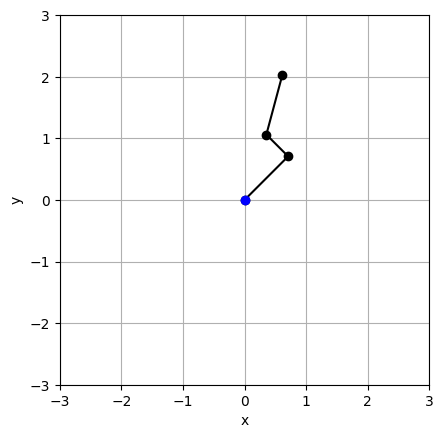

In [36]:
# Written by Youngwoo Sim

import numpy as np
from sympy import *
import matplotlib.pyplot as plt


# Step 1: Goal: understand/visualize the kinematics of 3-link manipulator

# define variables
# q: [3]:   joint angles (relative)
# L: [3]:   link lengths
q1, q2, q3, L1, L2, L3 = symbols('q1 q2 q3 L1 L2 L3')
q = Matrix([q1, q2, q3])
L = Matrix([L1, L2, L3])

# define coordinate frame (global orthonormal unit vectors)
xhat = Matrix([1,0])
yhat = Matrix([0,1])

# global joint angles
qa1 = q1
qa2 = q1 + q2
qa3 = q1 + q2 + q3

# directions of limbs
e1 = cos(qa1)*xhat + sin(qa1)*yhat
e2 = cos(qa2)*xhat + sin(qa2)*yhat
e3 = cos(qa3)*xhat + sin(qa3)*yhat

# joint positions
pb = Matrix([0, 0]);
p1 = L1*e1         # joint 1
p2 = p1 + L2*e2    # joint 2
p3 = p2 + L3*e3    # end-effector

# Jacobians and Positions of joints/end-effector (symbolic)
# Jsym = p3.jacobian([q1, q2, q3])
Jsym = p3.jacobian(q);
Psym = Matrix.hstack(pb, p1, p2, p3)

# convert symbolic expressions to functions
getJacobian = lambdify((q,L), Jsym)
getPositions = lambdify((q,L), Psym)

# evalulate the robot joint positions and jacobians
testJointAngles = [np.pi/4, np.pi/2, -np.pi/3]
testLinkLengths = [1, 0.5, 1]

testJacobian = getJacobian(testJointAngles, testLinkLengths)
testPositions = getPositions(testJointAngles, testLinkLengths)

print("Jacobian:")
display(Matrix(np.round(testJacobian, 3)))

# quick visualization
plt.figure()
plt.plot(testPositions[0,:], testPositions[1,:], 'k-o')    # robot chain
plt.plot(0, 0, 'bo')
plt.xlim([-3, 3])
plt.ylim([-3, 3])
plt.xlabel('x')
plt.ylabel('y')
plt.gca().set_aspect('equal', adjustable='box')
plt.grid(True)
plt.show()

In [47]:
# % Step 2
# % What we know is the relation between the torque and forces:
# %                           tau = J^T * f
# % Redundant manipulators have more number of actuators than the
# % dimensionality of the force (3>2). So, tau typically has infinite number
# % of solutions. But among those infinite solutions, the smallest solution
# % exists. Let's rewrite the equation as follows:
# %                       tau + tau_o = J^T * f
# %   tau_o:  is 'do-nothing-for-force' torque (has no effect on producing
# %           useful force on the end-effector)
# %   tau:    the smallest solution.
# % We can find tau using pseudo-inverse (pinv):   tau = pinv(J'T)*f

from scipy.linalg import null_space

# Renaming
J0 = testJacobian

# 3D torque
testTau = np.random.rand(3, 1)
print("testTau:\n", testTau)

# Calculate 2D force using pseudo-inverse
resultForce1 = np.linalg.pinv(J0.T).dot(testTau)
print("resultForce1:\n", resultForce1)

# An example of do-nothing-for-force torque
testTau0 = null_space(J0).dot(np.random.rand())
print("testTau0:\n", testTau0)

# Calculate 2D force again
resultForce2 = np.linalg.pinv(J0.T).dot(testTau + testTau0)

# Check if they are identical
difference = resultForce1 - resultForce2
print("difference:\n", difference)

# The output should show no differences between resultForce1 and resultForce2.
# What does this mean?


testTau:
 [[0.55550808]
 [0.81713017]
 [0.2637855 ]]
resultForce1:
 [[-0.55084602]
 [-0.93451221]]
testTau0:
 [[-0.02007453]
 [-0.00310554]
 [ 0.04636015]]
difference:
 [[-1.11022302e-16]
 [ 0.00000000e+00]]


In [53]:
# % Step 3: Goal: Vertex Searching - finding the intersection polygon
# % In the 3D joint torque space, we have two objects:
# %   1. a box (actuator limit)
# %   2. slice that defines the most efficient combination of torques to
# %      generate force at the end-effector.
# % The goal is to find the intersection of the box and the slice. In fact,
# % these objects can be expressed by linear equalities and inequalities.
# %
# % First, let's deal with the box.
# % The box is defined by 6 inequalities (x is torque):
# %   -3 <= x1 <= 2.5, -4 <= x2 <= 5,  -2 <= x3 <= 3.5
# % which can be converted into normal forms as follows
# %   1*x1 + 0*x2 + 0*x3 <= 2.5
# %   0*x1 + 1*x2 + 0*x3 <= 5
# %   0*x1 + 0*x2 + 1*x3 <= 3.5         % notice the identity matrix
# %  -1*x1 + 0*x2 + 0*x3 <= -(-3)
# %   0*x1 - 1*x2 + 0*x3 <= -(-4)
# %   0*x1 + 0*x2 - 1*x3 <= -(-2)       % notice the (-1)*identity matrix
# % These inequalities can be generally written in a matrix form:
# %   A * x <= b

# import cddlib
from scipy.spatial import ConvexHull

# Define the joint torque constraint - the box
#   UB: upper bound, LB: lower bound
A_UB = np.eye(3)
b_UB = np.array([2.5, 5, 3.5]).reshape(-1,1)  # torque upper bounds, try other values: [2.5; 5; 3.5];

A_LB = -np.eye(3)
b_LB = np.array([3, 4, 2]).reshape(-1,1)  # torque lower bounds (negated) try other values: [3; 4; 2];

# Concatenate vertically
A = np.vstack((A_UB, A_LB))
b = np.vstack((b_UB, b_LB))
print("A:\n", A)
print("b:\n", b)

# create polytope object
hRepBox = Hrep(A,b)
print(hRepBox)

# get vertices of the polytope
def getVertices(hRep):
    return hRep.generators

vertBox = getVertices(hRepBox);
print(vertBox)

vertBoxHull = ConvexHull(vertBox)
print(vertBoxHull.vertices)   # enumerates the order of the vertices


fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')

# Plot the opaque cube using plot_trisurf
ax.plot_trisurf(vertBoxHull.points[:, 0], vertBoxHull.points[:, 1], vertBoxHull.points[:, 2], triangles=vertBoxHull.simplices, alpha=0.2)
ax.scatter(vertBoxHull.points[:, 0], vertBoxHull.points[:, 1], vertBoxHull.points[:, 2], color='r', s=50)

# Set plot labels and show the plot
ax.set_xlabel('tau1')
ax.set_ylabel('tau2')
ax.set_zlabel('tau3')
plt.show()

A:
 [[ 1.  0.  0.]
 [ 0.  1.  0.]
 [ 0.  0.  1.]
 [-1. -0. -0.]
 [-0. -1. -0.]
 [-0. -0. -1.]]
b:
 [[2.5]
 [5. ]
 [3.5]
 [3. ]
 [4. ]
 [2. ]]


NameError: name 'Hrep' is not defined

In [20]:
# % Next, we define the slice (hyperplane containing origin). Remember,
# % points on the slice is the vector of actuator torques. One way to define
# % the slice is that any vector emanating from the origin and ends at a
# % point on the slice is perpendicular to the normal vector of the slice.
# %   normal vector:      nv = null(J);   J:[2 3],  nv:[3 1]
# %   torque:             x,  [3 1]
# %   slice expression:   nv'*x = 0
# % This equality can be generalized as follows (using two inequalities)
# %    Aeq * x <=  beq
# %   -Aeq * x <= -beq


nornalVecs = null_space(testJacobian);    # null space matrix of a jacobian
Aeq = np.transpose(nornalVecs);           # transpose of the normal vector
beq = np.zeros((Aeq.shape[0],1));         # beq is 0 because the slice passes origin

Aeq = np.vstack((Aeq, -Aeq))      # using two inequalities to define a equality
beq = np.vstack((beq, -beq))

A_slice = np.vstack((A, Aeq))     # combine slice and the box
b_slice = np.vstack((b, beq))

hRepSlice = Hrep(A_slice, b_slice)
vertSlice = getVertices(hRepSlice)
print(vertSlice)

fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.plot_trisurf(vertBoxHull.points[:, 0], vertBoxHull.points[:, 1], vertBoxHull.points[:, 2], triangles=vertBoxHull.simplices, alpha=0.2)
ax.scatter(vertBoxHull.points[:, 0], vertBoxHull.points[:, 1], vertBoxHull.points[:, 2], color='r', s=50)
ax.plot_trisurf(vertSlice[:, 0], vertSlice[:, 1], vertSlice[:, 2], alpha = 0.25)
ax.scatter(vertSlice[:, 0], vertSlice[:, 1], vertSlice[:, 2], color='b', s=50)
ax.set_xlabel('tau1')
ax.set_ylabel('tau2')
ax.set_zlabel('tau3')
plt.show()

# we might need better visualization
# such as: https://www.math.kit.edu/user/kaluba/publication/2020-random-polytopes/


NameError: name 'Hrep' is not defined

[[ 1.          1.73205081]
 [-1.         -1.73205081]
 [-0.6339746  -0.3660254 ]
 [ 1.          2.46410162]
 [-1.         -2.46410162]
 [ 0.6339746   0.3660254 ]]


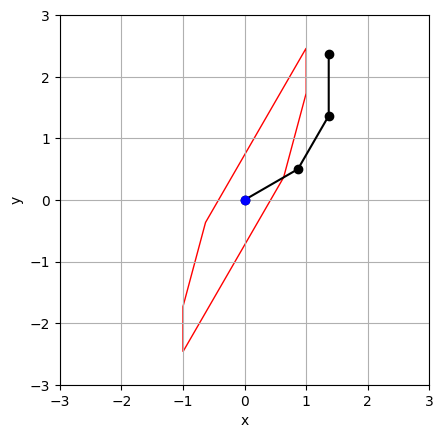

In [ ]:
# Finally, we can reproject the polygon onto the task space using the pinv()
vertSliceTask = np.linalg.pinv(J0.T).dot(vertSlice.transpose())
vertSliceTask = vertSliceTask.transpose()
vertSliceTaskHull = ConvexHull(vertSliceTask)
print(vertSliceTask)


# Create a polygon patch
import matplotlib.patches as patches
polygon = patches.Polygon(vertSliceTask[vertSliceTaskHull.vertices,:], closed=True, edgecolor='r', fill=False)

# Add the polygon patch to the axis
# quick visualization
# plt.figure()
fig, ax = plt.subplots()
plt.plot(testPositions[0,:], testPositions[1,:], 'k-o')    # robot chain
ax.add_patch(polygon)

plt.plot(0, 0, 'bo')
# plt.scatter(0, 0, color='r', marker='x')    # mark at origin
plt.xlim([-3, 3])
plt.ylim([-3, 3])
plt.xlabel('x')
plt.ylabel('y')
plt.gca().set_aspect('equal', adjustable='box')
plt.grid(True)
plt.show()

[[ 1.          1.73205081]
 [-1.         -1.73205081]
 [-0.6339746  -0.3660254 ]
 [ 1.          2.46410162]
 [-1.         -2.46410162]
 [ 0.6339746   0.3660254 ]]
[[ 2.3660254   4.09807621]
 [ 0.3660254   0.6339746 ]
 [ 0.73205081  2.        ]
 [ 2.3660254   4.83012702]
 [ 0.3660254  -0.09807621]
 [ 2.          2.73205081]]


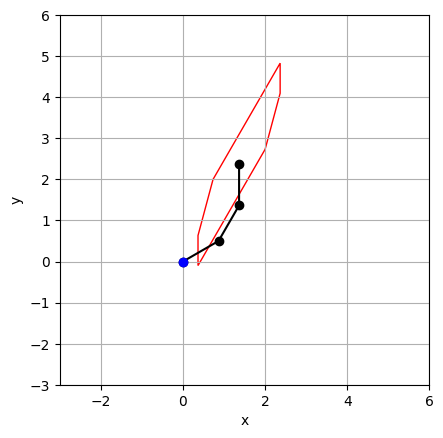

In [ ]:
# The issue with the previous visualization is that the red polygon is located at the origin, but we want it to be at the end-effector.

# Finally, we can reproject the polygon onto the task space using the pinv()
vertSliceTask = np.linalg.pinv(J0.T).dot(vertSlice.transpose())
vertSliceTask = vertSliceTask.transpose()
vertSliceTaskHull = ConvexHull(vertSliceTask)
print(vertSliceTask)

endEffectorPosition = testPositions[:,-1]

import numpy.matlib as npm
vertSliceTaskShift = vertSliceTask + npm.repmat(endEffectorPosition.transpose(), vertSliceTask.shape[0], 1)
print(vertSliceTaskShift)


# Create a polygon patch
import matplotlib.patches as patches
polygon = patches.Polygon(vertSliceTaskShift[vertSliceTaskHull.vertices,:], closed=True, edgecolor='r', fill=False)

# Add the polygon patch to the axis
# quick visualization
# plt.figure()
fig, ax = plt.subplots()
plt.plot(testPositions[0,:], testPositions[1,:], 'k-o')    # robot chain
ax.add_patch(polygon)

plt.plot(0, 0, 'bo')
# plt.scatter(0, 0, color='r', marker='x')    # mark at origin
plt.xlim([-3, 6])
plt.ylim([-3, 6])
plt.xlabel('x')
plt.ylabel('y')
plt.gca().set_aspect('equal', adjustable='box')
plt.grid(True)
plt.show()